# Φάση 2 – Σημασιολογική ανάκτηση χρησιμοποιώντας Transformers και FAISS

#### Ομάδα: Γιαννακοπούλου Μαρία-Βασιλική 3220026, Μανιάτης Ιωάννης 3220114

In [ ]:
!pip install pandas tqdm requests
!pip install transformers sentence-transformers torch
!pip install faiss-cpu 

In [ ]:
!pip install pandas sentence-transformers faiss-cpu tqdm
!pip install matplotlib seaborn

In [ ]:
!trec_eval.exe --help

# Imports

In [2]:
import pandas as pd
from pathlib import Path
import html
import re
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
import subprocess
import sys

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\hmani\Desktop\Semantic-search-Information-Retrieval-AUEB\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Ρυθμίσεις paths 
(σύμφωνα με την παρακάτω δομή)
```text
├── Phase2.ipynb
└── data
    ├── documents.csv
    ├── qrels.csv
    ├── qrels.txt
    ├── queries.csv
    └── queries.txt

In [4]:
CWD = Path.cwd()
DATA_DIR = CWD / "data" 
DOCUMENTS_CSV = DATA_DIR / "documents.csv"
QUERIES_CSV = DATA_DIR / "queries.csv"

# 2.1 Preprocessing
- Δεν αφαιρούμε stop-words καθώς τα transformers χρειάζονται τα συμφραζόμενα για να "καταλάβουν" τη σχέση μεταξύ λέξεων
- Το tokenization γίνεται από το ίδιο το μοντέλο στη συνέχεια

In [11]:
# Συνάρτηση Καθαρισμού Κειμένου
def clean_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = html.unescape(s)
    s = re.sub(r"[\x00-\x08\x0b\x0c\x0e-\x1f\x7f]+", " ", s)
    s = s.replace('\r', ' ').replace('\n', ' ')
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Διάβασμα CSV
df_docs = pd.read_csv(DOCUMENTS_CSV).fillna("")

print(f"Βρέθηκαν {len(df_docs)} έγγραφα.")
print(f"Στήλες αρχείου: {list(df_docs.columns)}")

# Καθαρίζουμε τη στήλη 'Text' και τη βάζουμε στο 'full_text'
if 'Text' in df_docs.columns:
    df_docs['full_text'] = df_docs['Text'].apply(clean_text)
else:
    raise ValueError("Δεν βρέθηκε στήλη 'Text'")

print("\nΔείγμα:")
print("-" * 50)
print(df_docs.head())

Βρέθηκαν 18316 έγγραφα.
Στήλες αρχείου: ['ID', 'Text']

Δείγμα:
--------------------------------------------------
       ID                                               Text  \
0  193157  Support towards the Europe PMC initiative-Cont...   
1  193158  Support to the Vice-Presidents of the ERC Scie...   
2  193159  Implementation of activities described in the ...   
3  193160  Monitoring Atmospheric Composition and Climate...   
4  193161  Pre-Operational Marine Service Continuity in T...   

                                           full_text  
0  Support towards the Europe PMC initiative-Cont...  
1  Support to the Vice-Presidents of the ERC Scie...  
2  Implementation of activities described in the ...  
3  Monitoring Atmospheric Composition and Climate...  
4  Pre-Operational Marine Service Continuity in T...  


# 2.2 Δημιουργία embeddings
Θα χρησιμοποιήσουμε το μοντέλο `all-MiniLM-L6-v2` καθώς είναι γρήγορο, μικρό και αποδοτικό για `semantic search` όπως αναφέρεται και στις αντίστοιχες διαφάνειες του μαθήματος

In [ ]:
# Ορίζουμε το μοντέλο (all-MiniLM-L6-v2)
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Μετατροπή στήλης full_text σε λίστα
sentences = df_docs['full_text'].tolist()

print(f"Δημιουργία embeddings για {len(sentences)} κείμενα...")

# Παραγωγή των embeddings
doc_embeddings = model.encode(sentences, batch_size=64, show_progress_bar=True, convert_to_numpy=True)

# Διαστάσεις
print(f"\nShape of embeddings: {doc_embeddings.shape}")

c:\Users\hmani\Desktop\Semantic-search-Information-Retrieval-AUEB\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hmani\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' pac

Δημιουργία embeddings για 18316 κείμενα...


Batches: 100%|██████████| 287/287 [19:02<00:00,  3.98s/it]



Shape of embeddings: (18316, 384)


In [15]:
# Αποθήκευση των embeddings
np.save(DATA_DIR / "doc_embeddings.npy", doc_embeddings)
print("Τα embeddings των κειμένων αποθηκεύτηκαν στο 'doc_embeddings.npy'")

Τα embeddings των κειμένων αποθηκεύτηκαν στο 'doc_embeddings.npy'


# 2.3 Δημιουργία ευρετηρίου FAISS

In [ ]:
# Ελέγχουμε ότι τα embeddings είναι float32 για το FAISS
# doc_embeddings = np.load(DATA_DIR / "doc_embeddings.npy")   # αν χρειαστεί να φορτωσουμε το αποθηκευμενο αρχειο
embeddings_faiss = doc_embeddings.astype('float32')     # το doc_embeddings παραμενει ανεπαφο

# L2 Normalization
faiss.normalize_L2(embeddings_faiss)

# Δημιουργία του Index
d = embeddings_faiss.shape[1]   # d = διάσταση των vectors (384 για το all-MiniLM-L6-v2)

# Χρησιμοποιούμε IndexFlatIP 
index = faiss.IndexFlatIP(d)

# Εισαγωγή των embeddings στο ευρετήριο
index.add(embeddings_faiss)

# Έλεγχος
print(f"Διάσταση (Dimension): {d}")
print(f"Σύνολο εγγράφων στο Index: {index.ntotal}")

Διάσταση (Dimension): 384
Σύνολο εγγράφων στο Index: 18316


# 2.4 Αναζήτηση και ανάκτηση

### α) Υπολογισμός embedding ερωτήματος
Περνάμε κάθε κείμενο ερώτησης, από το `queries.csv`, από το ίδιο μοντέλο transformers που χρησιμοποιήσαμε για τα έγγραφα, `all-MiniLM-L6-v2`

In [ ]:
# Διαβάζουμε το αρχείο queries.csv
df_queries = pd.read_csv(QUERIES_CSV).fillna("")

# Καθαρισμός του κειμένου των ερωτήσεων
df_queries['cleaned_text'] = df_queries['Text'].apply(clean_text)

print(f"Βρέθηκαν {len(df_queries)} ερωτήματα.")

print("Υπολογισμός embeddings ερωτημάτων:")
# Μετατροπή των ερωτήσεων σε vectors
query_embeddings = model.encode(
    df_queries['cleaned_text'].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"Shape ερωτημάτων: {query_embeddings.shape}")

Βρέθηκαν 10 ερωτήματα.
Υπολογισμός embeddings ερωτημάτων:


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]

Shape ερωτημάτων: (10, 384)


### β) Αναζήτηση στο FAISS των `k = 20, 30, 50` κοντινότερων κειμένων
Ζητάμε τα `50` πιο κοντινά κείμενα και έχουμε ανακτήσει και τα top-20 και τα top-30 αφού τα αποτελέσματα έρχονται ταξινομημένα 

In [ ]:
# Float32 και Κανονικοποίηση
queries_faiss = query_embeddings.astype('float32')
faiss.normalize_L2(queries_faiss)

# Αναζήτηση
k_max = 50
print(f"Εκτέλεση αναζήτησης για τα top-{k_max}...")

# D: Πίνακας με τα Scores (Ομοιότητα)
# I: Πίνακας με τα Indices (Θέση εγγράφου)
D, I = index.search(queries_faiss, k_max)

print("Η αναζήτηση ολοκληρώθηκε.")

Εκτέλεση αναζήτησης για τα top-50...
Η αναζήτηση ολοκληρώθηκε.


### γ) Αποτελέσματα ταξινομημένα κατά φθίνουσα ομοιότητα
Έρχονται ήδη ταξινομημένα (το πιο σχετικό πρώτο) βάσει cosine similarity. Τα παίρνουμε,  αντιστοιχίζουμε τα IDs και τα σώζουμε σε ξεχωριστά αρχεία

In [26]:
# Λίστα με τα k που μας ζητήθηκαν
k_values = [20, 30, 50]

# Θα αποθηκεύσουμε τα αποτελέσματα σε αρχεία με TREC format (ωστε να χρησιμοποιησουμε το trec_eval στο επόμενο βήμα)
# (QUERY_ID Q0 DOC_ID RANK SCORE RUN_NAME)

for k in k_values:
    filename = DATA_DIR / f"results_k{k}.txt"
    print(f"Δημιουργία αρχείου αποτελεσμάτων για k={k}: {filename.name}")
    
    with open(filename, 'w', encoding='utf-8') as f:
        # Για κάθε ερώτημα
        for q_idx in range(len(df_queries)):
            query_id = df_queries.iloc[q_idx]['ID']
            
            # Παίρνουμε μόνο τα πρώτα k αποτελέσματα από τα 50 που βρήκαμε
            # I[q_idx, :k] -> Οι δείκτες των k πρώτων εγγράφων
            # D[q_idx, :k] -> Τα scores των k πρώτων εγγράφων
            for rank, (doc_idx, score) in enumerate(zip(I[q_idx, :k], D[q_idx, :k]), start=1):
                
                # Αντιστοίχιση του δείκτη FAISS με το πραγματικό ID εγγράφου
                doc_id = df_docs.iloc[doc_idx]['ID']
                
                # Εγγραφή στο αρχείο
                line = f"{query_id} Q0 {doc_id} {rank} {score:.4f} FAISS_MiniLM\n"      # Q0 μπαινει παντα λογω TREC format
                f.write(line)

print("\nΤα αποτελέσματα αποθηκεύτηκαν.")

Δημιουργία αρχείου αποτελεσμάτων για k=20: results_k20.txt
Δημιουργία αρχείου αποτελεσμάτων για k=30: results_k30.txt
Δημιουργία αρχείου αποτελεσμάτων για k=50: results_k50.txt

Τα αποτελέσματα αποθηκεύτηκαν.


# 2.5 Αξιολόγηση με trec_eval

In [ ]:
def run_trec_eval(trec_eval_path, qrels_path, results_path):
    # Τρέχει το trec_eval.exe και επιστρέφει λεξικό με τα αποτελέσματα
    
    # Η εντολή που θα τρέξουμε στο cmd: trec_eval.exe -m map -m P.5,10,15,20 qrels.txt results.txt
    cmd = [
        str(trec_eval_path),
        "-m", "map",
        "-m", "P.5,10,15,20",
        str(qrels_path),
        str(results_path)
    ]
    
    print(f"Running: {' '.join(cmd)}")
    
    # Εκτέλεση της εντολής και καταγραφή της εξόδου
    process = subprocess.run(cmd, capture_output=True, text=True)
    
    if process.returncode != 0:
        print("Error running trec_eval:", process.stderr)
        return None

    # Format: "METRIC  all  VALUE"
    output_data = {}
    
    # Αποθηκεύουμε το k από το όνομα του αρχείου για τα διαγράμματα
    try:
        k_val = int(results_path.stem.split('_k')[-1])
    except:
        k_val = results_path.name

    output_data['retrieval_k'] = k_val

    for line in process.stdout.splitlines():
        parts = line.split()
        if len(parts) == 3:
            metric_name = parts[0]
            value = float(parts[2])
            
            # Αντιστοίχιση ονομάτων trec_eval με τα δικά μας για τα plots
            if metric_name == 'map':
                output_data['MAP'] = value
            elif metric_name.startswith('P_'):
                k = metric_name.split('_')[1]
                output_data[f'P@{k}'] = value

    # Εκτύπωση αποτελεσμάτων
    print("-" * 30)
    print(f"Results for {results_path.name}")
    print(f"MAP:  {output_data.get('MAP', 0):.4f}")
    print(f"P@5:  {output_data.get('P@5', 0):.4f}")
    print(f"P@10: {output_data.get('P@10', 0):.4f}")
    print(f"P@15: {output_data.get('P@15', 0):.4f}")
    print(f"P@20: {output_data.get('P@20', 0):.4f}")
    print("-" * 30)
    
    return output_data

# Ρυθμίσεις Paths
TREC_EVAL_EXE = CWD / "trec_eval.exe"       # Το exe πρεπει να ειναι στον φακελο του notebook

QRELS_FILE = DATA_DIR / "qrels.txt"
RESULTS_FILES = [
    DATA_DIR / "results_k20.txt",
    DATA_DIR / "results_k30.txt",
    DATA_DIR / "results_k50.txt"
]

# Εκτέλεση και Συλλογή Δεδομένων
all_metrics = []

if TREC_EVAL_EXE.exists():
    for res_file in RESULTS_FILES:
        if res_file.exists():
            metrics = run_trec_eval(TREC_EVAL_EXE, QRELS_FILE, res_file)
            if metrics:
                all_metrics.append(metrics)
else:
    print(f"Το αρχείο {TREC_EVAL_EXE} δεν βρέθηκε.")

# Δημιουργία DataFrame για διαχείριση και plotting
df_faiss = pd.DataFrame(all_metrics)
print("\nΣυγκεντρωτικά Αποτελέσματα:")
print(df_faiss)

Running: c:\Users\hmani\Desktop\Semantic-search-Information-Retrieval-AUEB\trec_eval.exe -m map -m P.5,10,15,20 c:\Users\hmani\Desktop\Semantic-search-Information-Retrieval-AUEB\data\qrels.txt c:\Users\hmani\Desktop\Semantic-search-Information-Retrieval-AUEB\data\results_k20.txt
------------------------------
Results for results_k20.txt
MAP:  0.3136
P@5:  0.6600
P@10: 0.5000
P@15: 0.3933
P@20: 0.3500
------------------------------
Running: c:\Users\hmani\Desktop\Semantic-search-Information-Retrieval-AUEB\trec_eval.exe -m map -m P.5,10,15,20 c:\Users\hmani\Desktop\Semantic-search-Information-Retrieval-AUEB\data\qrels.txt c:\Users\hmani\Desktop\Semantic-search-Information-Retrieval-AUEB\data\results_k30.txt
------------------------------
Results for results_k30.txt
MAP:  0.3416
P@5:  0.6600
P@10: 0.5000
P@15: 0.3933
P@20: 0.3500
------------------------------
Running: c:\Users\hmani\Desktop\Semantic-search-Information-Retrieval-AUEB\trec_eval.exe -m map -m P.5,10,15,20 c:\Users\hmani\Des

# Οπτικοποίηση αποτελεσμάτων

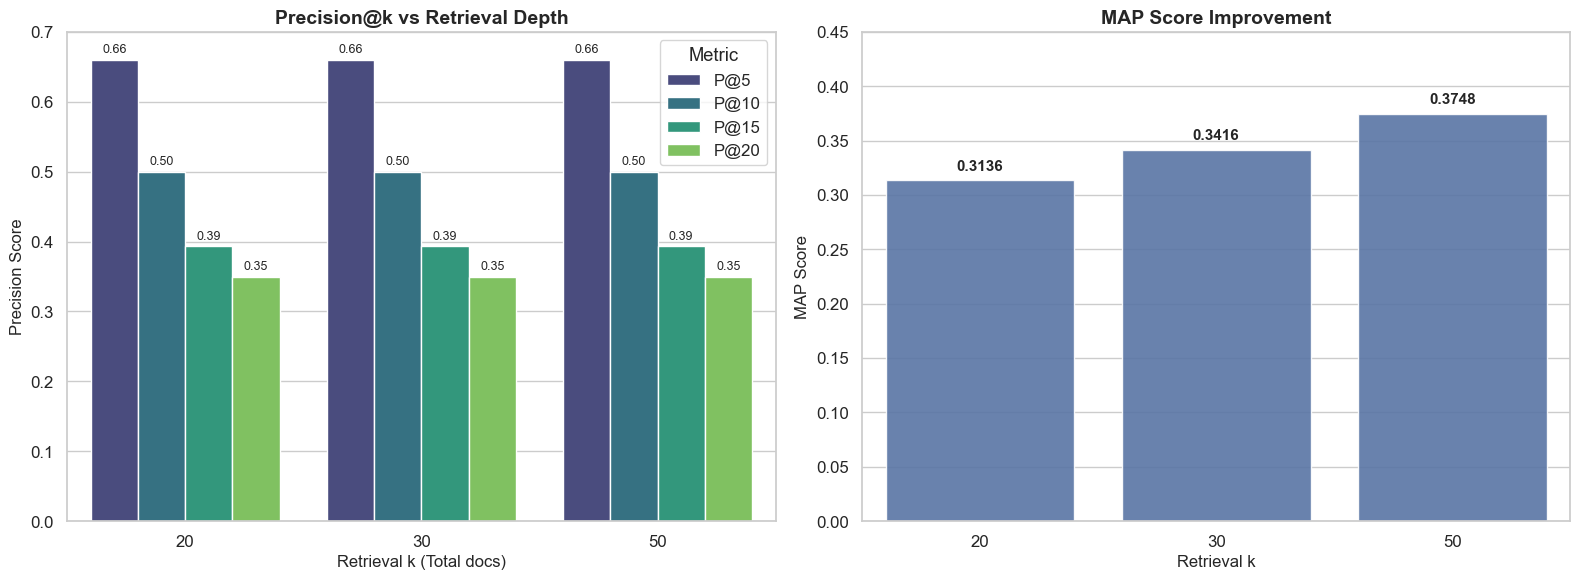

In [7]:
def visualize_metrics_bars(df):
    # Μετατροπή των δεδομένων για το seaborn 
    metrics_p = ["P@5", "P@10", "P@15", "P@20"]
    df_melt_p = df.melt(id_vars="retrieval_k", value_vars=metrics_p, 
                        var_name="Metric", value_name="Score")

    # Ρυθμίσεις εμφάνισης
    sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
    
    # Δημιουργία χώρου για 2 διαγράμματα
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Διάγραμμα 1 (Αριστερά): Grouped Bar Chart για Precision@k
    sns.barplot(
        data=df_melt_p, 
        x="retrieval_k", 
        y="Score", 
        hue="Metric", 
        palette="viridis",
        ax=ax1
    )
    ax1.set_title("Precision@k vs Retrieval Depth", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Retrieval k (Total docs)", fontsize=12)
    ax1.set_ylabel("Precision Score", fontsize=12)
    ax1.set_ylim(0, 0.7)
    ax1.legend(title="Metric", loc='upper right')

    # Προσθήκη τιμών στις μπάρες
    for p in ax1.patches:
        height = p.get_height()
        if height > 0:
            ax1.annotate(f'{height:.2f}', 
                         xy=(p.get_x() + p.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)

    # Διάγραμμα 2 (Δεξιά): Bar Chart για MAP
    df_melt_map = df.melt(id_vars="retrieval_k", value_vars=["MAP"], 
                          var_name="Metric", value_name="Score")
    
    barplot = sns.barplot(
        data=df_melt_map, 
        x="retrieval_k", 
        y="Score", 
        color="#4c72b0",
        alpha=0.9,
        ax=ax2
    )
    
    ax2.set_title("MAP Score Improvement", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Retrieval k", fontsize=12)
    ax2.set_ylabel("MAP Score", fontsize=12)
    ax2.set_ylim(0, 0.45)

    # Προσθήκη τιμών
    for p in barplot.patches:
        height = p.get_height()
        ax2.annotate(f'{height:.4f}', 
                     xy=(p.get_x() + p.get_width() / 2, height),
                     xytext=(0, 5), textcoords="offset points",
                     ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Εκτέλεση
visualize_metrics_bars(df_faiss)